In [1]:
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

This section presents the core ideas of reinforcement learning algorithm in their simplest form, in which the state and action spaces are small enough for the approximate value functions to be represented as arrays or tables. In this case, the methods can often find exactly the orpimal value function and the optimal policy, which contrasts with the approximate methods, which, by name definition, find only approximate solutions but can be applied to much larger problems.

### Action-value Methods

The methods used for estimating the values of actions and for using the estimated to make action selection decisions is called *action-value method*. The true value of an action is the mean reward when that action is selected - we can thus estimate this by averaging the rewards actually received. This is a simple method called *sample-average* method, and it's one of many, not necessarily the best one. 

We can take a *greedy* step and pick the best action based on previous experiences $A_t = argmax Q_t(a)$, which encourages *exploitation* of what we know is the best action given current state, or we can *explore* and pick a different, random action with probability $\epsilon$.

We can assess the effectiveness of the greedy and $\epsilon$-greedy action-value methods with ```K_ArmedBandit``` task. For any learning method we can measure its performance and behavior as it improves with experience over 1000 time steps (one *run*) when applied to the bandit problem.

In [153]:
class K_ArmedBandit():
   def __init__(self, k, loc=0., scale=1):
      self.k = k
      self.rewards = np.random.normal(loc=loc, scale=scale, size=k)
      self.optimal_action = np.argmax(self.rewards)
         
   def step(self, action:int):
      return np.random.normal(loc=self.rewards[action], scale=1)
         
   def plot(self, samples=2000, figsize=(10, 8)):
      distributions = []
      for v in self.rewards:
         distributions.append(np.random.normal(loc=v, scale=1, size=samples))
      
      # Main plot
      plt.figure(figsize=figsize)
      plt.plot([0]*self.k, linestyle='--', color='red', linewidth=1.)
      ax = sns.violinplot(data=distributions, color='white')
    
      # Label names
      plt.xlabel('Action')
      plt.ylabel('Reward distribution')

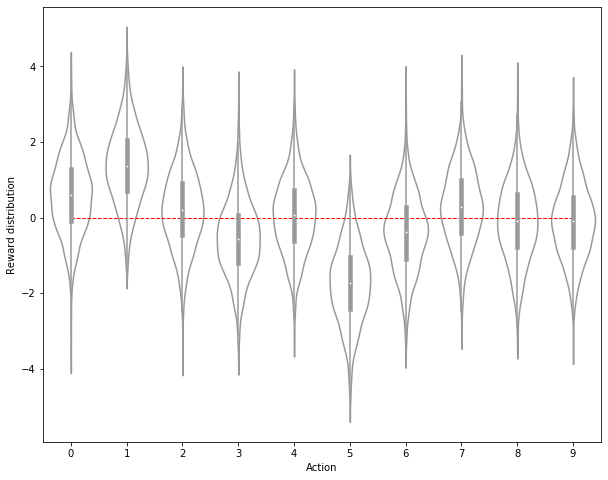

In [154]:
bandit = K_ArmedBandit(10)
bandit.plot()

In [286]:
class QTable():
   '''Simple Q-Table that store estimate reward for a given action by taking average of trials'''
   def __init__(self, action_size, init_value=None):
      self.Q = np.zeros(action_size) if init_value is None else np.full(action_size, init_value)
      self.seen_actions = np.zeros(action_size)
      self.avg_reward = 0.
      
   def update(self, action, reward, step_size=None):
      '''Sample-Average update rule using Incremental Implementation'''
      self.seen_actions[action] += 1
      if step_size is None:
         step_size = 1 / self.seen_actions[action]
      error = reward - self.Q[action]
      self.Q[action] = self.Q[action] + step_size*error
      
   def update_erwa(self, action, reward, alpha=0.1):
      '''
      Exponential Recency-Weighted Average.
      If alpha=0, only the most recent reward is included in calculations
      '''
      self.Q[action] = alpha*reward + (1-alpha)*self.Q[action]
      
   def update_gradient(self, action, reward, step, lr):
      '''Gradient ascent learning step'''
      self.avg_reward += (reward - self.avg_reward) / step
      pi = np.exp(self.Q) / np.sum(np.exp(self.Q))
      for a in range(len(self.Q)):
         if a == action: 
            self.Q[a] += lr*(reward-self.avg_reward)*(1-pi[a])
         else:
            self.Q[a] -= lr*(reward-self.avg_reward)*pi[a]
      
   def ubc_action(self, c, step):
      '''
      Upper-bound-confidence action selection, which encourages exploration
      prioritized by most other actions that most likely to be optimal
      '''
      ubc = np.log(step+1) / (self.seen_actions+1e-7)
      ubc = np.power(ubc, 1/c)
      actions = self.Q + ubc
      return np.argmax(actions)
   
   def softmax_action(self):
      '''Softmax'''
      pi = np.exp(self.Q) / np.sum(np.exp(self.Q))
      return np.random.choice(len(self.Q), size=1, p=pi)
      
   def argmax(self):
      return np.argmax(self.Q)
   
   def __len__(self):
      return len(self.Q)
      
   def __repr__(self):
      output = []
      for i, v in enumerate(self.Q):
         output.append(f'Action: {i}, Reward: {v}')
         
      return '\n'.join(output)
   
   def __getitem__(self, index):
      return self.Q[index]

   
def agent(bandit, action_size, steps=1000, eps=0., erwa=False, alpha=0.1, 
          init_value=None, ubc=False, c=2., gradient=False, lr=0.1):
   '''
   Agent using sample-average technique.
   Implements extra options such as Exponential Recency-Weighted Average or Upper-Bound-Confidence action selection
   '''
   Q = QTable(action_size, init_value=init_value)
   optimal_action = bandit.optimal_action
   expected_rewards = []
   actions_ratio = []
   
   for step in range(steps):
      # Pick action according to UBC or epsilon-greedy action
      if ubc:
         action = Q.ubc_action(c, step)
      elif gradient:
         action = Q.softmax_action()
      else:
         if np.random.random() < eps:
            action = np.random.randint(0, 10)
         else:
            action = Q.argmax()

      # Get reward for selected action
      reward = bandit.step(action)
      if erwa: Q.update_erwa(action, reward, alpha)
      elif gradient: Q.update_gradient(action, reward, (step+1), lr)
      else: Q.update(action, reward)
         
      # Store the reward and keep track of average ratio of selected optimal actions for interpreting
      expected_rewards.append(reward)
      if not actions_ratio:
         actions_ratio.append((action == optimal_action) / (step + 1))
      else:
         actions_ratio.append(actions_ratio[-1] + (((action == optimal_action) - actions_ratio[-1]) / (step + 1)))
      
   return Q, expected_rewards, actions_ratio

In [245]:
def monte_carlo(runs, eps=0., steps=1000, k=10, **kwargs):
   Qs = []
   avg_results = []
   avg_optimal_actions = []
   for i in range(runs):
      bandit = K_ArmedBandit(k)
      Q, expected_rewards, optimal_action = agent(bandit, k, steps, eps, **kwargs)
      Qs.append(Q)
      avg_results.append(expected_rewards)
      avg_optimal_actions.append(optimal_action)
      
   return Qs, np.mean(np.array(avg_results), axis=0), np.mean(np.array(avg_optimal_actions), axis=0)

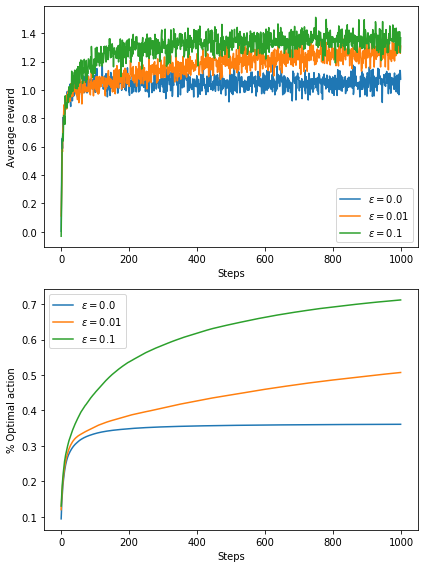

In [247]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

for eps in (0.0, 0.01, 0.1):
   _, mean_rewards, mean_optimals = monte_carlo(500, eps)
   axs[0].plot(mean_rewards, label=r'$\epsilon={}$'.format(eps))
   axs[1].plot(mean_optimals, label=r'$\epsilon={}$'.format(eps))
   
axs[0].legend()
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Average reward')

axs[1].legend()
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('% Optimal action')

plt.tight_layout()
plt.show()

As shown in the chart, greedy method performed much worse compared to the best possible score of about 1.55 on this task - that's because it got stuck performic suboptimal actions as it didn't get to explore new possibilities. 

Let's explore how **Exponential Recency-Weighted Average** performs. The key idea is that the old rewards are less important than the new one, thus we pay give them less weight - this is especially important in cases where the problem is non-stationary and reward signal can change over time.

It's worth noting that for the choice $\alpha_n(a)=\frac{1}{n}$ results in the sample-average method is guaranteed to converge to true action values by the law of large numbers, but this is not the case for constant step-size parameter $\alpha$ such as in case of *erwa*, which indicates that the estimates never completely converge, but continue to vary in response tot he most recently received rewards. By no means this is wrong - in fact, this is desirable in a nonstationary environment, which are most common problems in reinforcement learning. 

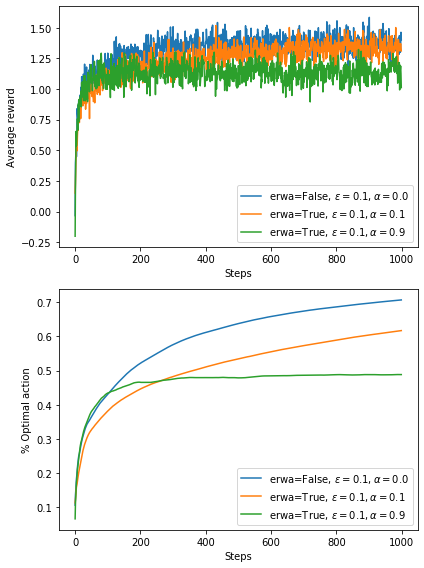

In [294]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

for erwa, alpha in zip([False, True, True], [0.0, 0.1, 0.9]):
   _, mean_rewards, mean_optimals = monte_carlo(300, 0.1, erwa=erwa, alpha=alpha)
   axs[0].plot(mean_rewards, label=r'erwa={}, $\epsilon=0.1, \alpha={}$'.format(erwa, alpha))
   axs[1].plot(mean_optimals, label=r'erwa={}, $\epsilon=0.1, \alpha={}$'.format(erwa, alpha))
   
axs[0].legend()
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Average reward')

axs[1].legend()
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('% Optimal action')

plt.tight_layout()
plt.show()

All methods mentioned so far are *biased*, in a sense that they depend to some extent on the initial action-value estimates $Q_1(a)$. For sample-average methods, the bias disappears once all actions have been selected at least once, but for methods with constant step size $\alpha$, the bias is permanent, though decreasing over time. In practice, this is not a problem and can even be helpful. The question is: what should be the initial set of parameters?

Initial action values can be used as a simple way to encourage exploration. Suppose instead of setting all actions to 0, we set them to 5 instead, which is wildly optimistic for problem with distribution of mean 0 and variance 1. Whichever action is initially selected, the reward will be less than the starting estimate of 5, making the learner to switch to other actions - forcing the agent to try all the actions before the value estimates converge - even with greedy policy. This technique is called **optimistic initial values**, it is quite effective on stationary problems, but not for non-stationary problems as its drive for exploration is only temporary - if the task changes in the middle of a run, this method cannot help and will keep exploiting the action it found most useful earlier.

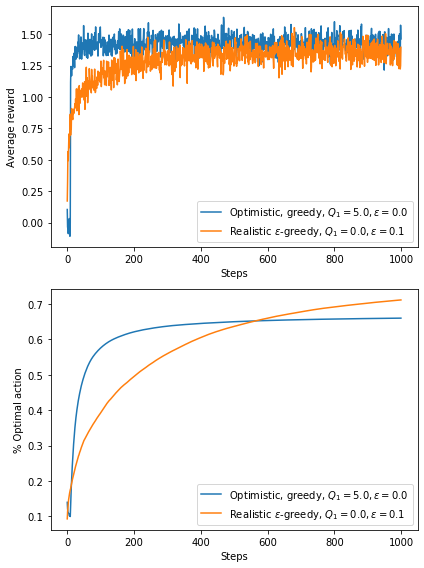

In [295]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

for eps, q, label in zip((0.0, 0.1), (5.0, 0.0), ('Optimistic, greedy', 'Realistic $\epsilon$-greedy')):
   _, means, optimals = monte_carlo(300, eps, init_value=q)
   axs[0].plot(means, label=r'{}, $Q_1={}, \epsilon={}$'.format(label, q, eps))
   axs[1].plot(optimals, label=r'{}, $Q_1={}, \epsilon={}$'.format(label, q, eps))
   
axs[0].legend()
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Average reward')

axs[1].legend()
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('% Optimal action')

plt.tight_layout()
plt.show()

The optimistic and greedy polict outperforms the choice with epsilon and initial values all set to 0. However, any method that focuses on initial conditions in any special way in unlikely to help with the general nonstationary case. After all, beginning of time occurs only once and there shouldn't be too much focus put towards it.

Exploration is needed as there is always uncertainty about the accuracy of the action-value estimates. $\epsilon$-greedy policy does provide a chance to select different actions at random, without any preference for those taht are nearly greedy or particularly uncertain. It would make sense to select among the non-greedy actions according to their potential for actually being optimal. This is the core objective behind the **Upper-Confidence-Bound (UCB)** Action Selection:

$$A_t=argmax_a \left[Q_t(a)+c\sqrt{\frac{\ln t}{N_t(a)}} \right]$$

where $N_t(a)$ denotes the number of times that action $a$ has been selected prior to time $t$ and the number $c \gt 0$ controls the degree of exploration. If $N_t(a) = 0$ then $a$ is considered to be maximizing action. The intuition behind is that the square-root term is a measure of the uncertainty or variance in the estimate of $a$'a value - the quantity measures by ```argmax``` is a sort of *upper bound* on the possible true value of action $a$, with $c$ determining the confidence level.

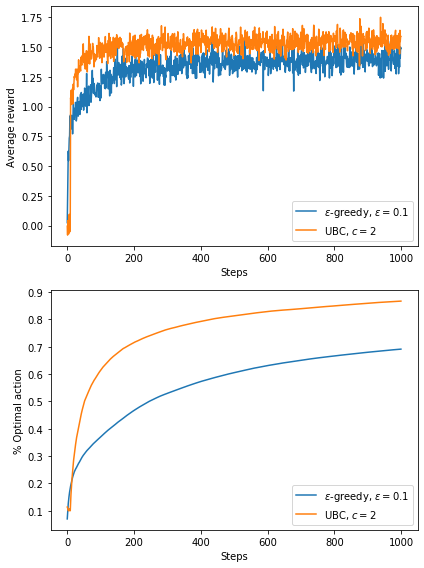

In [296]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

for eps, ubc, label in zip((0.1, 0.0), (False, True), (r'$\epsilon$-greedy, $\epsilon=0.1$', 'UBC, $c=2$')):
   _, means, optimals = monte_carlo(300, eps=eps, ubc=ubc)
   axs[0].plot(means, label=label)
   axs[1].plot(optimals, label=label)

axs[0].legend()
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Average reward')

axs[1].legend()
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('% Optimal action')

plt.tight_layout()
plt.show()

Another way to solve this problem is to learn a numerical *preference* for each action $a$, denoted as $H_t(a)$ - the larger the preference, the more likely that action is taken, although there is no interpretation in terms of reward. This is what **Gradient Bandit Algorithms** do. The action is picked via *softmax*:

$$\pi_t(a) = \frac{e^{H_t(a)}}{\sum^k_{b=t}e^{H_t(b)}}$$

where $\pi_t(a)$ is the probability of taking action $a$ at time $t$.

For each step, after selecting an action $A_t$ and recieving reward $R_t$, action preferences are updated via *Gradient Ascent*:

$$
\begin{align}
H_{t+1}(A_t)=H_t(A_t)+\alpha(R_t-\hat R_t)\left(1-\pi_t(A_t)\right), && \text{and} \\
H_{t+1}(a) = H_t(a) - \alpha(R_t - \hat R_t)\pi_t(a),                && \text{for all}\space  a \neq A_t
\end{align}
$$,

where $\alpha$ is a step-size parameter and $\hat R_t$ is the average of all the rewards up through and including ime $t$.

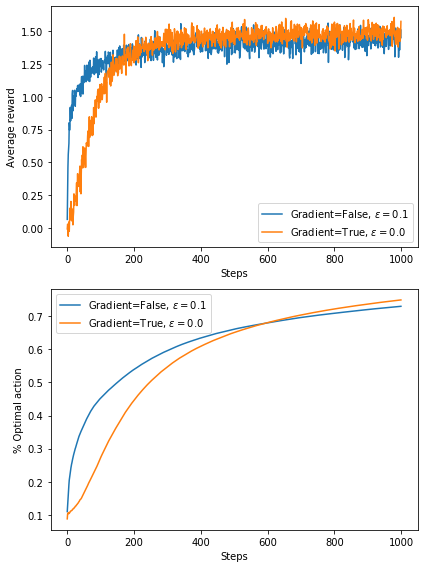

In [297]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

for eps, gradient in zip((0.1, 0.0), (False, True)):
   _, mean_rewards, mean_optimals = monte_carlo(300, eps=eps, gradient=gradient)
   axs[0].plot(mean_rewards, label=r'Gradient={}, $\epsilon={}$'.format(gradient, eps))
   axs[1].plot(mean_optimals, label=r'Gradient={}, $\epsilon={}$'.format(gradient, eps))
   
axs[0].legend()
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Average reward')

axs[1].legend()
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('% Optimal action')

plt.tight_layout()
plt.show()

Now, the above task was simple, stationary task where agent could see a singe bandit machine and learn which lever to pull after doing multiple trials. In reality, *associative search* tasks are more common, where we are given bandits at random at each step. This might be difficult to predict which lever to pull now, but if we know some information about each bandit given - for example, its color - the agent could then associate that with red bandit level 1 is the best choice, while blue, it's level 4. These are called **associatative** tasks, because they involve both trial-and-error learning to *search* for the best actions, and *association* of those actions with the situations in which they are best. Other name for these kind of tasks is **contextual bandits**.

Basically, it's like a 2-dimensional Q-table, where rows are the different bandits agent sees and columns represent each layer. The values in that column are expected returns for each state-lever pair. We will look into those problems in the next chapter.